In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import data_utils as ut
from os import listdir

Here we perform the following operations:
- Creation of the final metadata file
- Parsing of the changeO output to have a table that contains all the necessary (and not useless) information for the next analysis. In particular we filter for small read counts, we keep only productive sequences andwe  add the information of the H-L paired sequences. At the end we export in the sequence folder a table for each experimental replicate
- For each sample we also merge all the experimental replicates and we export these sample-wise tables

## Setting up the metadata frame

In [2]:
def load_sample_times(path='metadata/metadata_times.txt'):
    f = open(path, 'r')
    times = dict()
    for l in f.readlines():
        if l[0] == '#':
            continue
        pat, cell, time_id, time = l.split('\t')
        samp_id = pat+'_'+time_id+'_'+cell
        times[samp_id] = time[:-1]
    return times

def load_group_name_dict(path='metadata/metadata_group_name.txt'):
    f = open(path, 'r')
    group_name_dict = dict()
    for l in f.readlines():
        if l[0] == '#':
            continue
        group_name_dict[int(l.split('\t')[0][1:])] = l.split('\t')[1][:-1]
    return group_name_dict

In [3]:
group_name_dict = load_group_name_dict()
time_dict = load_sample_times()
metadata = pd.DataFrame(index=time_dict.keys())
metadata['group_index'] = metadata.index.map({v:k for k,v in group_name_dict.items()})
metadata['patient'] = metadata.index.str[3]
metadata['cell'] = metadata.index.str[8]
metadata['time_id'] = metadata.index.str[6]
metadata['time'] = metadata.index.map(time_dict)

In [4]:
metadata

,group_index,patient,cell,time_id,time
pat1_t1_mc,9,1,m,1,2010
pat1_t2_mc,6,1,m,2,2020
pat1_t1_pc,12,1,p,1,jun2018
pat1_t2_pc,13,1,p,2,nov2018
pat1_t3_pc,3,1,p,3,sep2020
pat1_t4_pc,11,1,p,4,feb2021
pat2_t1_mc,2,2,m,1,2014
pat2_t2_mc,8,2,m,2,may2020
pat2_t3_mc,7,2,m,3,jul2020
pat2_t1_pc,5,2,p,1,2014


## A few checks on a data-point

In [5]:
data_dir = 'changeO_out/'
sample = 'g2_1a'
f = pd.read_csv(data_dir+sample+'/filtered_contig_igblast_db-pass.tsv', sep='\t', index_col='sequence_id')

In [6]:
print('n seqs', len(f))
print('productive fraction', sum(f.productive=='T') / len(f))

n seqs 17675
productive fraction 1.0


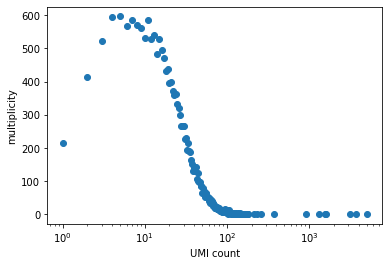

In [7]:
umi_c = f.umi_count.values
uni_umi_c, count_umi_c = np.unique(umi_c, return_counts=True)
plt.xlabel('UMI count')
plt.ylabel('multiplicity')
plt.scatter(uni_umi_c, count_umi_c)
plt.xscale('log')

In [8]:
def replicate_preprocess(f, min_umi_count=2):
    """
    Preprocessing that discard unproductive and small umi counts, filters V and J calls,
    creates the chain field and keeps only a subsets of fields.
    """
    
    f = f[f.productive == 'T']
    f = f[f['umi_count'] >= min_umi_count]
    
    # Keeping only the top-score V and J genes
    f.v_call = f.v_call.str.split(',').str[0]
    f.j_call = f.j_call.str.split(',').str[0]
    
    # Labels for heavy or light chains
    f['chain'] = 'L'
    f.loc[f.locus == 'IGH', 'chain'] = 'H'
    
    return f[['sequence', 'v_call', 'chain', 'j_call', 'sequence_alignment', 'germline_alignment', 
            'junction', 'junction_aa', 'locus', 'c_call', 'junction_length', 'v_sequence_start',
            'v_sequence_end', 'v_germline_start', 'v_germline_end', 'j_sequence_start', 
            'j_sequence_end', 'j_germline_start', 'j_germline_end', 'cell_id']]

def find_paired_seq(f):
    """
    Crating two new fields: n_seqs_in_cell says how many sequences have been found in the cell,
    paired_seq contains the id of the paired sequence found in the same cell.
    paired_seq is nan for all the sequences that do not have a correct pairing with the opposite chain.
    """
    
    # Auxiliary frame that maps cell ids to the chain type of the seqs they contain
    f['sequence_id'] = f.index
    cell_id_to_index = f.groupby('cell_id').agg({'chain' : list, 'sequence_id' : list})
    cell_id_to_index['n_seqs_in_cell'] = cell_id_to_index.chain.str.len()
    
    # To have a good H-L pairing the list of chains has to contain 2 elements...
    good_cell_mask1 = cell_id_to_index.n_seqs_in_cell == 2
    # ... and those elements has to be one heavy and one light
    cell_id_to_index.loc[good_cell_mask1, 'chain1'] = cell_id_to_index.loc[good_cell_mask1, 'chain'].str[0]
    cell_id_to_index.loc[good_cell_mask1, 'chain2'] = cell_id_to_index.loc[good_cell_mask1, 'chain'].str[1]
    good_cell_mask2 = cell_id_to_index.chain1 != cell_id_to_index.chain2
    # Mask that signal which sequence has a unique pairing
    good_pair_mask = np.logical_and(good_cell_mask1, good_cell_mask2)

    # The number of seqs that the cell contain is also added to the original dataframe
    f['n_seqs_in_cell'] = f.cell_id.map(cell_id_to_index.n_seqs_in_cell)
    
    # Creating the field that contains the index of the paired seq, if Nan the paired sequence does not exists
    cell_id_to_index.loc[good_pair_mask, 'seq_id1'] = cell_id_to_index.loc[good_pair_mask, 'sequence_id'].str[0]
    cell_id_to_index.loc[good_pair_mask, 'seq_id2'] = cell_id_to_index.loc[good_pair_mask, 'sequence_id'].str[1]
    pair_seq_dict1 = cell_id_to_index[good_pair_mask].groupby('seq_id1').agg({'seq_id2' : 'first'}).seq_id2.to_dict()
    pair_seq_dict2 = cell_id_to_index[good_pair_mask].groupby('seq_id2').agg({'seq_id1' : 'first'}).seq_id1.to_dict()
    pair_seq_dict = {**pair_seq_dict1, **pair_seq_dict2}
    f['paired_seq'] = f.index.map(pair_seq_dict)
    return f.drop(['sequence_id'], axis=1)


def collapse_same_seqs(f):
    """
    For sequences with a correct H-L pairing, it collapse on the same line the identical sequences 
    with also identical paired sequence.
    For sequences found alone in the cell it collapses for identical sequence.
    All the other sequences are not collapsed.
    """
    
    if 'pair_count' not in f.columns:
        f['pair_count'] = 1
    f['sequence_id'] = f.index
    f['seq_id_list'] = f.index
    agg_dict = {k:'first' for k in f.columns}
    agg_dict['pair_count'] = sum
    agg_dict['seq_id_list'] = list
    
    # Collapsing the sequences being alone in their cell
    seq_alone_f = f[f.n_seqs_in_cell == 1].groupby('sequence', as_index=False).agg(agg_dict)

    # collapsing the good pairs if the have the same heavy and light sequence
    cell_id_to_index = f[f.paired_seq.notna()].groupby('cell_id').agg({'chain' : list, 'sequence' : list})
    cell_id_to_index['chain1'] = cell_id_to_index['chain'].str[0]
    cell_id_to_index['chain2'] = cell_id_to_index['chain'].str[1]
    H_mask = cell_id_to_index['chain1'] == 'H'
    cell_id_to_index.loc[H_mask, 'joint_seq'] = cell_id_to_index.loc[H_mask, 'sequence'].str[0] + cell_id_to_index.loc[H_mask, 'sequence'].str[1]
    L_mask = cell_id_to_index['chain1'] == 'L'
    cell_id_to_index.loc[L_mask, 'joint_seq'] = cell_id_to_index.loc[L_mask, 'sequence'].str[1] + cell_id_to_index.loc[L_mask, 'sequence'].str[0]
    f['joint_seq'] = f.cell_id.map(cell_id_to_index['joint_seq'])
    f['joint_seq'] = f['joint_seq'] + f['chain']
    seq_pairs_f = f[f.paired_seq.notna()].groupby('joint_seq', as_index=False).agg(agg_dict)
    
    no_collapse_m = np.logical_or(f.n_seqs_in_cell > 2, np.logical_and(f.n_seqs_in_cell == 2, f.paired_seq.isna()))
    f = pd.concat((seq_alone_f, seq_pairs_f, f[no_collapse_m]))
    f.index = f.sequence_id
    collapse_m = np.logical_or(f.n_seqs_in_cell == 1, f.paired_seq.notna())
    collapsed_ids = f[collapse_m][f[collapse_m].seq_id_list.str.len() > 1]['seq_id_list']
    return f.drop(['sequence_id', 'joint_seq', 'seq_id_list'], axis=1).fillna(float('nan')), collapsed_ids

## Processing technical replicates and saving them

In [9]:
metadata['repl_count'] = 0

for sample in listdir('changeO_out/'):
    
    if sample[0] != 'g':
        continue
        
    group = sample.split('_')[0][1:]
    s_name = group_name_dict[int(group)]
    metadata.loc[s_name, 'repl_count'] += 1
    sr_name = s_name + '_r' + str(metadata.loc[s_name, 'repl_count'])
    
    f = pd.read_csv(data_dir+sample+'/filtered_contig_igblast_db-pass.tsv', sep='\t', index_col='sequence_id')
    f = replicate_preprocess(f)
    f = find_paired_seq(f)
    f, collapsed_ids = collapse_same_seqs(f)
    f.to_csv('sequences/replicates/'+sr_name+'.tsv', sep='\t')
    ut.write_collapsed_ids(collapsed_ids, 'sequences/replicates/'+sr_name+'_collapsed_ids.txt')

    print(sr_name)

pat1_t4_pc_r1
pat2_t3_pc_r1
pat1_t1_pc_r1
pat2_t1_mc_r1
pat2_t2_mc_r1
pat2_t2_pc_r1
pat2_t1_mc_r2
pat2_t3_pc_r2
pat1_t2_pc_r1
pat2_t1_pc_r1
pat1_t4_pc_r2
pat2_t3_mc_r1
pat1_t3_pc_r1
pat1_t2_mc_r1
pat2_t2_pc_r2
pat1_t1_mc_r1
pat2_t2_pc_r3
pat2_t1_mc_r3
pat1_t2_mc_r2
pat2_t2_mc_r2
pat2_t4_pc_r1
pat1_t4_pc_r3
pat1_t3_pc_r2
pat1_t3_pc_r3
pat1_t3_pc_r4
pat2_t2_mc_r3
pat1_t2_mc_r3
pat1_t3_pc_r5
pat1_t4_pc_r4
pat1_t4_pc_r5
pat1_t4_pc_r6
pat1_t2_mc_r4
pat1_t1_mc_r2
pat2_t1_mc_r4
pat2_t1_mc_r5
pat1_t1_pc_r2
pat2_t4_pc_r2
pat2_t3_mc_r2
pat1_t1_mc_r3
pat1_t3_pc_r6
pat1_t4_pc_r7
pat1_t2_pc_r2
pat1_t1_mc_r4
pat2_t2_mc_r4
pat2_t3_mc_r3
pat2_t2_mc_r5
pat2_t3_mc_r4
pat1_t3_pc_r7
pat1_t1_mc_r5
pat1_t2_mc_r5
pat2_t3_mc_r5


## Merging technical replicates and exporting them

In [10]:
def get_inverse_collapse(collapsed_ids):
    
    inverse_collapse = dict()
    for new_id, ids in collapsed_ids.items():
        for _id in ids:
            inverse_collapse[_id] = new_id
            
    inv_collapse_fr = pd.DataFrame(index=inverse_collapse.keys())
    inv_collapse_fr['new_id'] = inv_collapse_fr.index.map(inverse_collapse)
    aux_ids = inv_collapse_fr.index.str.split('_').str
    inv_collapse_fr['replicate'] = aux_ids[1].str[1]
    inv_collapse_fr['old_id'] = aux_ids[0] + '_' + aux_ids[2] + '_' + aux_ids[3]
    return inv_collapse_fr

In [16]:
for s_id, meta in metadata.iterrows():

#for s_id in ['pat1_t2_mc']:
#    meta = metadata.loc[s_id]
    
    frame = pd.DataFrame()
    repl_frames = dict()
    c = 0
    
    for i in range(meta.repl_count):
        r_id = s_id + '_r' + str(i+1)
        f = pd.read_csv('sequences/replicates/'+r_id+'.tsv', sep='\t', index_col=0)
        repl_frames[i+1] = f.copy()
        
        # making unique the ids (there can be overlaps between replicates of cell ids)
        f.cell_id = f.cell_id + '_r' + str(i+1)
        f.index = f.cell_id + '_contig_' + f.index.str.split('_').str[-1]
        m = f.paired_seq.notna()
        f.loc[m, 'paired_seq'] = f.loc[m, 'cell_id'] + '_contig_' + f.loc[m, 'paired_seq'].str.split('_').str[-1]
        c += f.pair_count.sum()
        
        frame = pd.concat((frame, f))
    
    # Same collapsing rule of the replicates
    frame, collapsed_ids = collapse_same_seqs(frame)
    frame.pair_count = np.array(frame.pair_count, dtype=int)
    frame.to_csv('sequences/'+s_id+'.tsv', sep='\t')
    
    # Remapping collapsed ids on the replicates
    inv_collapse = get_inverse_collapse(collapsed_ids)
    for i in range(meta.repl_count):
        id_map = inv_collapse[inv_collapse.replicate == str(i+1)].groupby('old_id').agg({'new_id' : 'first'}).new_id
        repl_frames[i+1]['sample_id'] = repl_frames[i+1].index.map(id_map)
        # Mapping non collapsed ids
        mask = repl_frames[i+1].sample_id.isna()
        aux_ids = repl_frames[i+1][mask].index.str.split('_').str
        repl_frames[i+1].loc[mask, 'sample_id'] = aux_ids[0] + '_r'  + str(i+1) + '_' + aux_ids[1] + '_' + aux_ids[2]
        repl_frames[i+1].to_csv('sequences/replicates/'+s_id + '_r' + str(i+1)+'.tsv', sep='\t')
        
    print(s_id, 'count check', c == frame.pair_count.sum())

pat1_t1_mc count check True
pat1_t2_mc count check True
pat1_t1_pc count check True
pat1_t2_pc count check True
pat1_t3_pc count check True
pat1_t4_pc count check True
pat2_t1_mc count check True
pat2_t2_mc count check True
pat2_t3_mc count check True
pat2_t1_pc count check True
pat2_t2_pc count check True
pat2_t3_pc count check True
pat2_t4_pc count check True


In [55]:
metadata.to_csv('metadata/metadata.tsv', sep='\t')